# Import

In [1]:
from tsfast.basics import *
from fastai.basics import *
import json
import os
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from scipy.io import savemat

In [2]:
# create dataloader for silverbox dataset
dls = create_dls_silverbox(bs=16,win_sz=200,stp_sz=20)

## LSTM

Train LSTM-network with 1 Layer:

epoch,train_loss,valid_loss,fun_rmse,time
0,0.009446,0.008316,0.015922,00:06
1,0.006850,0.007085,0.015383,00:05


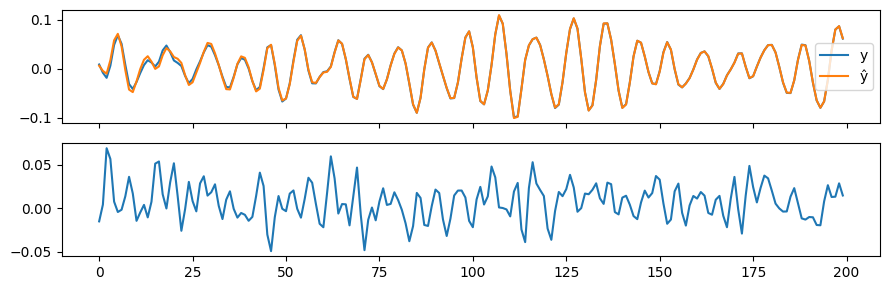

In [54]:
lrn_lstm_1 = RNNLearner(dls,rnn_type='lstm', hidden_size=64,num_layers=1)
lrn_lstm_1.fit_flat_cos(n_epoch=2)
lrn_lstm_1.show_results(max_n=1)

Train LSTM-network with 3 Layers:

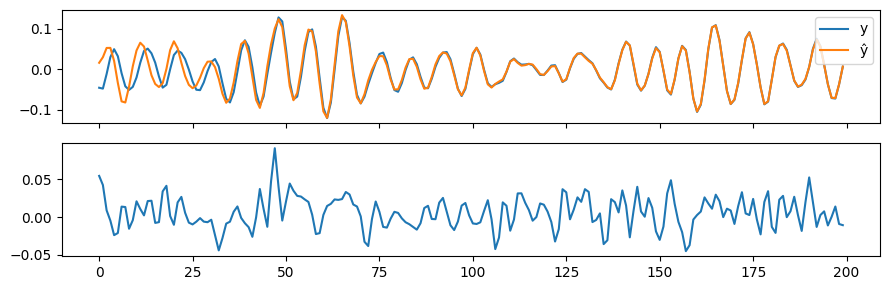

In [55]:
lrn_lstm_3 = RNNLearner(dls,rnn_type='lstm', hidden_size=32,num_layers=3)
lrn_lstm_3.fit_flat_cos(n_epoch=2)
lrn_lstm_3.show_results(max_n=1)

In [56]:
def export_LSTM(lrn, path=None, filename="LSTM_model.json"):
    """
    Export a trained stacked LSTM model from a tsfast / fastai Learner to JSON.

    The JSON contains:
      - meta: model sizes, dtype, column names, normalization
      - weights: LSTM gate weights per layer + output head

    Parameters
    ----------
    lrn : fastai Learner
        Trained learner containing a stacked LSTM model.
    path : str or Path or None
        Output directory (default: "models").
    filename : str
        JSON filename (default: "LSTM_model.json").

    Returns
    -------
    Path
        Path to the written JSON file.

    Notes
    -----
    PyTorch LSTM gate order in weight_ih / weight_hh chunks is:
      input (i), forget (f), cell (g), output (o)
    """

    # --------------------------------------------------
    # Output path
    # --------------------------------------------------
    out_dir = Path(path) if path is not None else Path("models")
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / filename

    # --------------------------------------------------
    # Model access
    # --------------------------------------------------
    if not hasattr(lrn, "model"):
        raise ValueError("export_LSTM: Learner has no model.")

    model = lrn.model

    if not hasattr(model, "rnn") or not hasattr(model.rnn, "rnns"):
        raise ValueError("export_LSTM: model.rnn.rnns not found.")

    rnns = list(model.rnn.rnns)
    if len(rnns) == 0:
        raise ValueError("export_LSTM: No LSTM layers found.")

    # Output head (tsfast default)
    if hasattr(model, "final") and hasattr(model.final, "lin"):
        head = model.final.lin
    elif hasattr(model, "head"):
        head = model.head
    else:
        raise ValueError("export_LSTM: Output head not found.")

    # --------------------------------------------------
    # Infer dimensions
    # --------------------------------------------------
    first = rnns[0]
    input_size = int(first.input_size)
    hidden_size = int(first.hidden_size)
    num_layers = len(rnns)

    if hasattr(head, "out_features"):
        output_size = int(head.out_features)
    else:
        output_size = int(head.weight.shape[0])

    try:
        dtype = str(next(model.parameters()).dtype).replace("torch.", "")
    except StopIteration:
        dtype = "unknown"

    rnn_type = getattr(model.rnn, "rnn_type", "LSTM")

    # --------------------------------------------------
    # Column names (best effort)
    # --------------------------------------------------
    input_columns = None
    output_columns = None
    try:
        dls = lrn.dls
        if hasattr(dls[-1], "clm_names"):
            input_columns = dls[-1].clm_names[0]
            output_columns = dls[-1].clm_names[1]
    except Exception:
        pass

    # --------------------------------------------------
    # Normalization (inputs only, best effort)
    # --------------------------------------------------
    norm = {}
    try:
        tfm = lrn.dls.after_batch
        if hasattr(tfm, "mean") and hasattr(tfm, "std"):
            norm["mean"] = tfm.mean.detach().cpu().numpy().tolist()
            norm["std"] = tfm.std.detach().cpu().numpy().tolist()
            norm["axes"] = list(getattr(tfm, "axes", ()))
    except Exception:
        pass

    # --------------------------------------------------
    # Helper
    # --------------------------------------------------
    def to_list(t):
        return t.detach().cpu().numpy().tolist()

    # --------------------------------------------------
    # Collect LSTM weights
    # PyTorch gate order: input, forget, cell, output
    # --------------------------------------------------
    weights = {}

    for li, lstm in enumerate(rnns):

        for attr in ("weight_ih_l0", "weight_hh_l0", "bias_ih_l0", "bias_hh_l0"):
            if not hasattr(lstm, attr):
                raise ValueError(f"export_LSTM: Layer {li} is missing {attr}")

        w_ih = lstm.weight_ih_l0.chunk(4, 0)
        b_ih = lstm.bias_ih_l0.chunk(4, 0)
        w_hh = lstm.weight_hh_l0.chunk(4, 0)
        b_hh = lstm.bias_hh_l0.chunk(4, 0)

        gates = ("i", "f", "g", "o")

        for g, t in zip(gates, w_ih):
            weights[f"w_i{g}_l{li}"] = to_list(t)
        for g, t in zip(gates, b_ih):
            weights[f"b_i{g}_l{li}"] = to_list(t)
        for g, t in zip(gates, w_hh):
            weights[f"w_h{g}_l{li}"] = to_list(t)
        for g, t in zip(gates, b_hh):
            weights[f"b_h{g}_l{li}"] = to_list(t)

    # --------------------------------------------------
    # Output layer
    # --------------------------------------------------
    weights["weight_linout"] = to_list(head.weight)
    weights["bias_linout"] = to_list(head.bias) if head.bias is not None else None

    # --------------------------------------------------
    # Meta
    # --------------------------------------------------
    meta = {
        "input_size": input_size,
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "rnn_type": rnn_type,
        "output_size": output_size,
        "dtype": dtype,
        "input_columns": input_columns,
        "output_columns": output_columns,
        "norm": norm,
    }

    # --------------------------------------------------
    # Write JSON
    # --------------------------------------------------
    export = {"meta": meta, "weights": weights}

    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(export, f, indent=2, ensure_ascii=False)

    print(f"LSTM JSON exportiert nach: {out_path}")
    
    return out_path

In [57]:
export_LSTM(lrn=lrn_lstm_1,filename="LSTM_model_1layer.json")
export_LSTM(lrn=lrn_lstm_3,filename="LSTM_model_3layer.json")

LSTM JSON exportiert nach: models\LSTM_model_1layer.json
LSTM JSON exportiert nach: models\LSTM_model_3layer.json


Path('models/LSTM_model_3layer.json')

# GRU

GRU with 1 Layer:

epoch,train_loss,valid_loss,fun_rmse,time
0,0.009149,0.007609,0.015453,00:20
1,0.006952,0.006966,0.015392,00:34


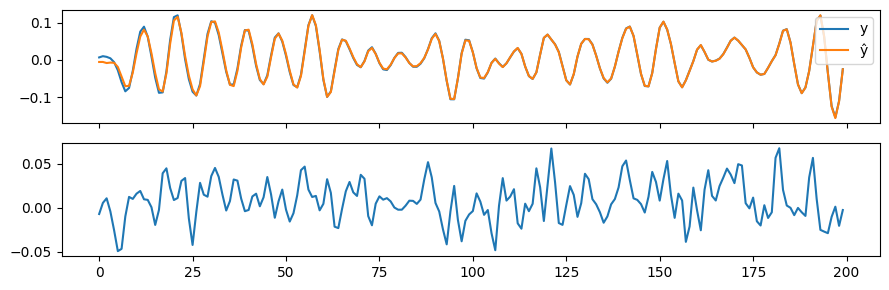

In [3]:
lrn_gru_1 = RNNLearner(dls,rnn_type='gru',hidden_size=64,num_layers=1)
lrn_gru_1.fit_flat_cos(n_epoch=2)
lrn_gru_1.show_results(max_n=1)

GRU with 3 Layers: 

epoch,train_loss,valid_loss,fun_rmse,time
0,0.009299,0.007935,0.015640,00:49
1,0.006738,0.007076,0.015393,01:05


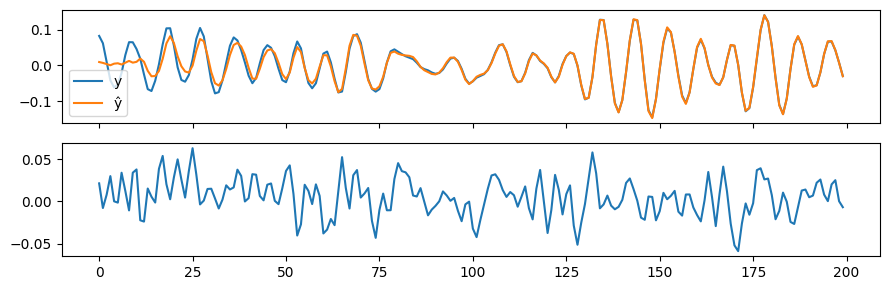

In [5]:
lrn_gru_3 = RNNLearner(dls,rnn_type='gru',hidden_size=32,num_layers=3)
lrn_gru_3.fit_flat_cos(n_epoch=2)
lrn_gru_3.show_results(max_n=1)

In [6]:
def export_GRU(lrn, path=None, filename="GRU_model.json"):
    """
    Export a trained stacked GRU model from a tsfast / fastai Learner to JSON.

    The JSON contains:
      - meta: model sizes, dtype, column names, normalization
      - weights: GRU gate weights per layer + output head

    Parameters
    ----------
    lrn : fastai Learner
        Trained learner containing a stacked GRU model.
    path : str or Path or None
        Output directory (default: "models").
    filename : str
        JSON filename (default: "GRU_model.json").

    Returns
    -------
    Path
        Path to the written JSON file.
    """

    # --------------------------------------------------
    # Output path
    # --------------------------------------------------
    out_dir = Path(path) if path is not None else Path("models")
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / filename

    # --------------------------------------------------
    # Model access
    # --------------------------------------------------
    if not hasattr(lrn, "model"):
        raise ValueError("export_GRU: Learner has no model.")

    model = lrn.model

    if not hasattr(model, "rnn") or not hasattr(model.rnn, "rnns"):
        raise ValueError("export_GRU: model.rnn.rnns not found.")

    rnns = list(model.rnn.rnns)
    if len(rnns) == 0:
        raise ValueError("export_GRU: No GRU layers found.")

    # Output head (tsfast default)
    if hasattr(model, "final") and hasattr(model.final, "lin"):
        head = model.final.lin
    elif hasattr(model, "head"):
        head = model.head
    else:
        raise ValueError("export_GRU: Output head not found.")

    # --------------------------------------------------
    # Infer dimensions
    # --------------------------------------------------
    first = rnns[0]
    input_size = int(first.input_size)
    hidden_size = int(first.hidden_size)
    num_layers = len(rnns)

    if hasattr(head, "out_features"):
        output_size = int(head.out_features)
    else:
        output_size = int(head.weight.shape[0])

    try:
        dtype = str(next(model.parameters()).dtype).replace("torch.", "")
    except StopIteration:
        dtype = "unknown"

    rnn_type = getattr(model.rnn, "rnn_type", "GRU")

    # --------------------------------------------------
    # Column names (best effort)
    # --------------------------------------------------
    input_columns = None
    output_columns = None
    try:
        dls = lrn.dls
        if hasattr(dls[-1], "clm_names"):
            input_columns = dls[-1].clm_names[0]
            output_columns = dls[-1].clm_names[1]
    except Exception:
        pass

    # --------------------------------------------------
    # Normalization (inputs only, best effort)
    # --------------------------------------------------
    norm = {}
    try:
        tfm = lrn.dls.after_batch
        if hasattr(tfm, "mean") and hasattr(tfm, "std"):
            norm["mean"] = tfm.mean.detach().cpu().numpy().tolist()
            norm["std"] = tfm.std.detach().cpu().numpy().tolist()
            norm["axes"] = list(getattr(tfm, "axes", ()))
    except Exception:
        pass

    # --------------------------------------------------
    # Helper
    # --------------------------------------------------
    def to_list(t):
        return t.detach().cpu().numpy().tolist()

    # --------------------------------------------------
    # Collect GRU weights
    # PyTorch gate order: reset, update, new
    # --------------------------------------------------
    weights = {}

    for li, gru in enumerate(rnns):

        for attr in ("weight_ih_l0", "weight_hh_l0", "bias_ih_l0", "bias_hh_l0"):
            if not hasattr(gru, attr):
                raise ValueError(f"export_GRU: Layer {li} is missing {attr}")

        w_ih = gru.weight_ih_l0.chunk(3, 0)
        b_ih = gru.bias_ih_l0.chunk(3, 0)
        w_hh = gru.weight_hh_l0.chunk(3, 0)
        b_hh = gru.bias_hh_l0.chunk(3, 0)

        gates = ("r", "z", "n")

        for g, t in zip(gates, w_ih):
            weights[f"w_i{g}_l{li}"] = to_list(t)
        for g, t in zip(gates, b_ih):
            weights[f"b_i{g}_l{li}"] = to_list(t)
        for g, t in zip(gates, w_hh):
            weights[f"w_h{g}_l{li}"] = to_list(t)
        for g, t in zip(gates, b_hh):
            weights[f"b_h{g}_l{li}"] = to_list(t)

    # --------------------------------------------------
    # Output layer
    # --------------------------------------------------
    weights["weight_linout"] = to_list(head.weight)
    weights["bias_linout"] = to_list(head.bias) if head.bias is not None else None

    # --------------------------------------------------
    # Meta
    # --------------------------------------------------
    meta = {
        "input_size": input_size,
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "rnn_type": rnn_type,
        "output_size": output_size,
        "dtype": dtype,
        "input_columns": input_columns,
        "output_columns": output_columns,
        "norm": norm,
    }

    # --------------------------------------------------
    # Write JSON
    # --------------------------------------------------
    export = {"meta": meta, "weights": weights}

    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(export, f, indent=2, ensure_ascii=False)
        
    print(f"GRU JSON exportiert nach: {out_path}")

    return out_path

In [8]:
export_GRU(lrn=lrn_gru_1,filename="GRU_model_1layer.json")
export_GRU(lrn=lrn_gru_3,filename="GRU_model_3layer.json")

GRU JSON exportiert nach: models\GRU_model_1layer.json
GRU JSON exportiert nach: models\GRU_model_3layer.json


Path('models/GRU_model_3layer.json')

# FNN

This is just a small demo of how it could look, as no FNN is currently implemented in tsfast as far as i know.

In [12]:
# Define a simple feedforward network with 1 Layer
class SimpleFeedforward_1Layer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        batch_size, seq_len, features = x.shape
        x = x.reshape(-1, features)            # (batch_size * seq_len, features)
        out = self.layers(x)                   # (batch_size * seq_len, output_size)
        out = out.reshape(batch_size, seq_len, -1)
        return out


# Define a simple feedforward network with 3 Layers
class SimpleFeedforward_3Layer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        batch_size, seq_len, features = x.shape
        x = x.reshape(-1, features)
        out = self.layers(x)
        out = out.reshape(batch_size, seq_len, -1)
        return out

In [13]:
inp_size, out_size = get_inp_out_size(dls)

In [14]:
model_FNN_1Layer = SimpleFeedforward_1Layer(inp_size, 64, out_size)
model_FNN_3Layer = SimpleFeedforward_3Layer(inp_size, 32, out_size)

In [15]:
# model_FNN_1Layer = nn.Sequential(
#     nn.Linear(inp_size, 64),
#     nn.ReLU(),
#     nn.Linear(64, out_size),
# )

# model_FNN_3Layer = nn.Sequential(
#     nn.Linear(inp_size, 32),
#     nn.ReLU(),
#     nn.Linear(32, 32),
#     nn.ReLU(),
#     nn.Linear(32, 32),
#     nn.ReLU(),
#     nn.Linear(32, 32),
# )

epoch,train_loss,valid_loss,fun_rmse,time
0,0.003286,0.003075,0.055437,00:02
1,0.002969,0.002957,0.054366,00:01


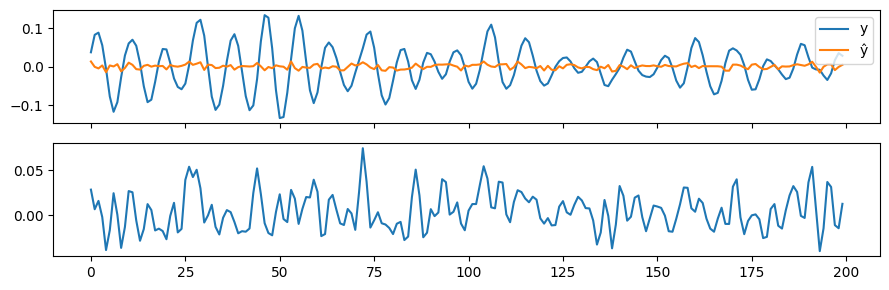

In [16]:
lrn_fnn_1 = Learner(dls, model_FNN_1Layer, loss_func=nn.MSELoss(),  metrics=[fun_rmse])
lrn_fnn_1.fit_flat_cos(n_epoch=2)
lrn_fnn_1.show_results(max_n=1)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.002927,0.002942,0.054231,00:01
1,0.002961,0.002941,0.054218,00:01


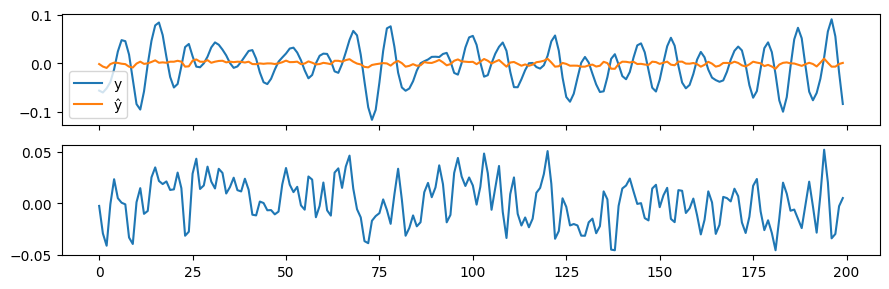

In [17]:
lrn_fnn_3 = Learner(dls, model_FNN_3Layer, loss_func=nn.MSELoss(),  metrics=[fun_rmse])
lrn_fnn_3.fit_flat_cos(n_epoch=2)
lrn_fnn_3.show_results(max_n=1)

In [18]:
def export_FNN(lrn, path=None, filename="FNN_model.json"):
    """
    Export a trained feedforward (nn.Sequential) model from a tsfast / fastai Learner to JSON.

    The JSON contains:
      - meta: model sizes, dtype, column names, normalization
      - weights: per-layer Linear weights/biases in forward order

    Parameters
    ----------
    lrn : fastai Learner
        Trained learner containing an FNN model (ideally nn.Sequential of Linear/ReLU/etc.).
    path : str or Path or None
        Output directory (default: "models").
    filename : str
        JSON filename (default: "FNN_model.json").

    Returns
    -------
    Path
        Path to the written JSON file.
    """
    out_dir = Path(path) if path is not None else Path("models")
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / filename

    if not hasattr(lrn, "model"):
        raise ValueError("export_FNN: Learner has no model.")
    model = lrn.model

    def to_list(t):
        return t.detach().cpu().numpy().tolist()

    # Column names (best effort)
    input_columns = None
    output_columns = None
    try:
        dls = lrn.dls
        if hasattr(dls[-1], "clm_names"):
            input_columns = dls[-1].clm_names[0]
            output_columns = dls[-1].clm_names[1]
    except Exception:
        pass

    # Normalization (inputs only, best effort)
    norm = {}
    try:
        tfm = lrn.dls.after_batch
        if hasattr(tfm, "mean") and hasattr(tfm, "std"):
            norm["mean"] = tfm.mean.detach().cpu().numpy().tolist()
            norm["std"] = tfm.std.detach().cpu().numpy().tolist()
            norm["axes"] = list(getattr(tfm, "axes", ()))
    except Exception:
        pass

    # Collect Linear layers in forward order
    linear_layers = []
    for m in model.modules():
        if m is model:
            continue
        if m.__class__.__name__ == "Linear" or m.__class__ is __import__("torch").nn.Linear:
            linear_layers.append(m)

    if len(linear_layers) == 0:
        raise ValueError("export_FNN: No nn.Linear layers found in lrn.model.")

    # Infer dimensions from first/last Linear
    input_size = int(linear_layers[0].in_features)
    output_size = int(linear_layers[-1].out_features)
    hidden_sizes = [int(l.out_features) for l in linear_layers[:-1]]
    num_linear_layers = len(linear_layers)

    try:
        dtype = str(next(model.parameters()).dtype).replace("torch.", "")
    except StopIteration:
        dtype = "unknown"

    weights = {}
    for i, lin in enumerate(linear_layers):
        weights[f"linear_{i}_weight"] = to_list(lin.weight)
        weights[f"linear_{i}_bias"] = to_list(lin.bias) if lin.bias is not None else None
        weights[f"linear_{i}_in_features"] = int(lin.in_features)
        weights[f"linear_{i}_out_features"] = int(lin.out_features)

    meta = {
        "model_type": "FNN",
        "input_size": input_size,
        "output_size": output_size,
        "hidden_sizes": hidden_sizes,
        "num_linear_layers": num_linear_layers,
        "dtype": dtype,
        "input_columns": input_columns,
        "output_columns": output_columns,
        "norm": norm,
    }

    export = {"meta": meta, "weights": weights}

    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(export, f, indent=2, ensure_ascii=False)

    print(f"FNN JSON exportiert nach: {out_path}")
    return out_path

In [19]:
export_FNN(lrn=lrn_fnn_1,filename="FNN_model_1layer.json")
export_FNN(lrn=lrn_fnn_3,filename="FNN_model_3layer.json")

FNN JSON exportiert nach: models\FNN_model_1layer.json
FNN JSON exportiert nach: models\FNN_model_3layer.json


Path('models/FNN_model_3layer.json')

# Save Data

Save the Silverbox data as .mat file

In [20]:
def save_test_dls_as_mat(dls, save_path="data.mat"):
    """
    Save the test DataLoader (dls[-1]) as a .mat file.
    Stores only:
      - X (inputs)
      - Y (targets)
      - input_names
      - output_names

    Assumptions:
      - dls[-1] is the test set
      - the test set is not batched
      - exactly one sample is stored
    """

    # --- get data ---
    X, Y = dls[-1].dataset[0]

    # convert torch tensors to numpy if necessary
    try:
        import torch
        if isinstance(X, torch.Tensor): X = X.cpu().numpy()
        if isinstance(Y, torch.Tensor): Y = Y.cpu().numpy()
    except Exception:
        pass

    # --- get column names ---
    input_names, output_names = dls[-1].clm_names

    # --- save to .mat ---
    save_path = Path(save_path)
    save_path.parent.mkdir(parents=True, exist_ok=True)

    savemat(
        save_path,
        {
            "X": np.asarray(X),
            "Y": np.asarray(Y),
            "input_names": np.array(input_names, dtype=object),
            "output_names": np.array(output_names, dtype=object),
        },
        do_compression=True,
    )

    return save_path

In [21]:
save_test_dls_as_mat(dls, "silverbox_data.mat")

Path('silverbox_data.mat')